In [1]:
from typing import Dict, Optional
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from xcube.core.store import new_data_store
from xcube.core.select import select_variables_subset

## Prepare I/O directories

In [2]:
clip_repo_name = "clip_05_burning_lands"

In [3]:
from init_nb import ws_path, cliplib
clip_dir = ws_path / clip_repo_name
clip_data_dir = clip_dir / "data"
clip_cache_dir = clip_data_dir / "temp"
if not clip_cache_dir.exists():
    clip_cache_dir.mkdir()

Open CCI Open Data Portal store and list contents:

In [4]:
odp_store = new_data_store("cciodp")

In [5]:
# list(cz_store.get_data_ids())

In [6]:
data_id = "esacci.FIRE.mon.L4.BA.MODIS.Terra.MODIS_TERRA.v5-1.grid"

## Inspect CCI Fire data cube

In [7]:
odp_store.describe_data(data_id)

/opt/conda/lib/python3.9/site-packages/xcube_cci/cciodp.py:1260: CciOdpWarning: Variable "vegetation_class_name" has no fill value, cannot set one. For parts where no data is available you will see random values. This is usually the case when data is missing for a time step.
  warnings.warn(f'Variable "{fixed_key}" has no fill value, '


## Open CCI Fire data cube, Burned Area

In [8]:
odp_store.get_open_data_params_schema()

In [9]:
ba_dataset = odp_store.open_data(data_id, variable_names=["burned_area"])
ba_dataset

<xarray.Dataset>
Dimensions:           (time: 240, lat: 720, lon: 1440, nv: 2, bnds: 2,
                       vegetation_class: 18)
Coordinates:
  * lat               (lat) float32 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
    lat_bnds          (lat, nv) float32 dask.array<chunksize=(720, 2), meta=np.ndarray>
  * lon               (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    lon_bnds          (lon, nv) float32 dask.array<chunksize=(1440, 2), meta=np.ndarray>
  * time              (time) datetime64[ns] 2001-01-16T12:00:00 ... 2020-12-1...
    time_bnds         (time, bnds) datetime64[ns] dask.array<chunksize=(240, 2), meta=np.ndarray>
  * vegetation_class  (vegetation_class) int32 10 20 30 40 ... 150 160 170 180
Dimensions without coordinates: nv, bnds
Data variables:
    burned_area       (time, lat, lon) float32 dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.FIRE.mon.L4.BA.MODIS.Terra.MODIS_TERRA.v5...
    date_created:            2023-01-23T10:21:20.591426
    processing_level:        L4
    time_coverage_start:     2001-01-01T00:00:00
    time_coverage_end:       2021-01-01T00:00:00
    time_coverage_duration:  P7305DT0H0M0S
    history:                 [{'program': 'xcube_cci.chunkstore.CciChunkStore...

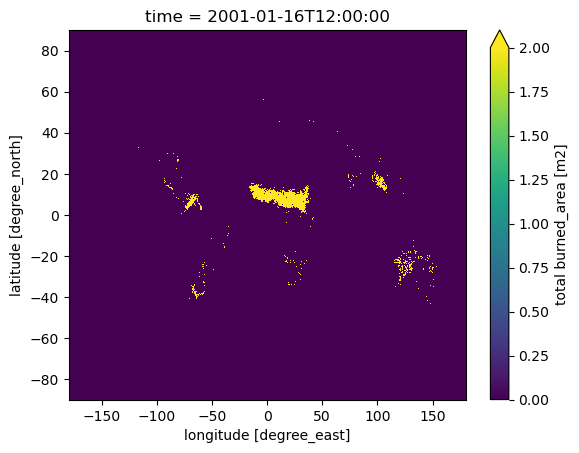

In [10]:
ba_dataset.burned_area.isel(time=0).plot.imshow(vmax=2)

## Get the rasterized countries for Burned Areas

In [11]:
countries_dataset = cliplib.make_countries_dataset(ba_dataset, dir_path=clip_cache_dir)

## Get spatial subsets for Europe

In [12]:
spatial_slices = cliplib.get_spatial_slices_for_mask(countries_dataset.europe)
spatial_slices

{'lon': slice(-24.125, 39.875, None), 'lat': slice(80.625, 35.125, None)}

In [13]:
countries_subset = countries_dataset.sel(spatial_slices)
countries_subset = countries_subset.chunk(dict(lon="auto", lat="auto"))

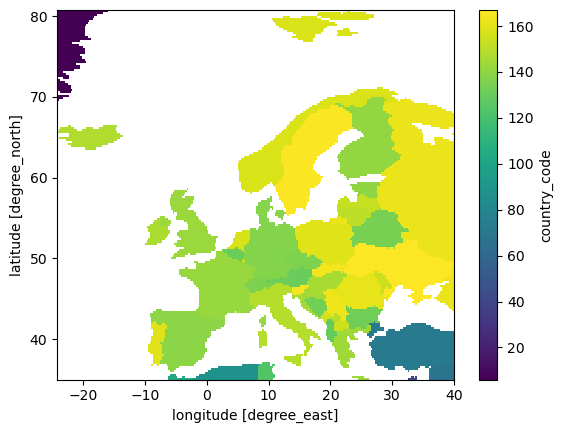

In [14]:
countries_subset.country_code.plot.imshow()

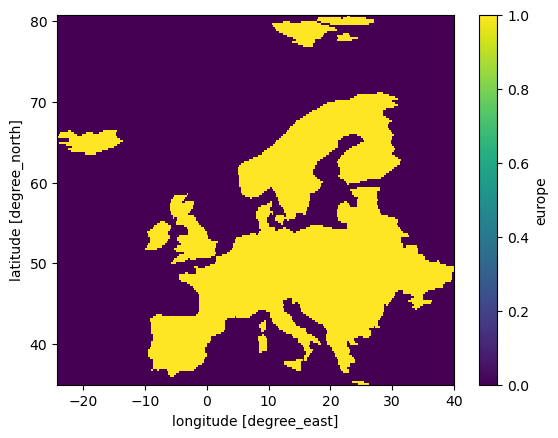

In [15]:
countries_subset.europe.plot.imshow()

## Spatial subset of Burned Areas 

In [16]:
ba_subset = ba_dataset.sel(spatial_slices)
ba_subset

<xarray.Dataset>
Dimensions:           (time: 240, lat: 183, lon: 257, nv: 2, bnds: 2,
                       vegetation_class: 18)
Coordinates:
  * lat               (lat) float32 80.62 80.38 80.12 ... 35.62 35.38 35.12
    lat_bnds          (lat, nv) float32 dask.array<chunksize=(183, 2), meta=np.ndarray>
  * lon               (lon) float32 -24.12 -23.88 -23.62 ... 39.38 39.62 39.88
    lon_bnds          (lon, nv) float32 dask.array<chunksize=(257, 2), meta=np.ndarray>
  * time              (time) datetime64[ns] 2001-01-16T12:00:00 ... 2020-12-1...
    time_bnds         (time, bnds) datetime64[ns] dask.array<chunksize=(240, 2), meta=np.ndarray>
  * vegetation_class  (vegetation_class) int32 10 20 30 40 ... 150 160 170 180
Dimensions without coordinates: nv, bnds
Data variables:
    burned_area       (time, lat, lon) float32 dask.array<chunksize=(1, 183, 97), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.FIRE.mon.L4.BA.MODIS.Terra.MODIS_TERRA.v5...
    date_created:            2023-01-23T10:21:20.591426
    processing_level:        L4
    time_coverage_start:     2001-01-01T00:00:00
    time_coverage_end:       2021-01-01T00:00:00
    time_coverage_duration:  P7305DT0H0M0S
    history:                 [{'program': 'xcube_cci.chunkstore.CciChunkStore...

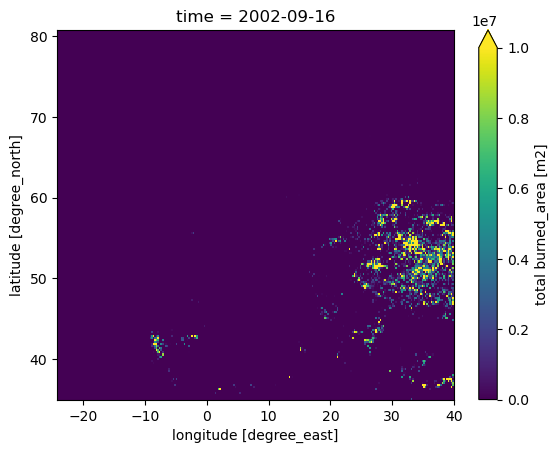

In [17]:
ba_subset.burned_area.isel(time=20).plot.imshow(vmax=1e7)

## Burned Areas annual maximum values

In [18]:
ba_annual_group = ba_subset.resample(time="Y")
ba_annual_group

DatasetResample, grouped over '__resample_dim__'
20 groups with labels 2001-12-31, ..., 2020-12-31.

In [19]:
# ba_annual = ba_annual_group.max(["time"])
ba_annual = ba_annual_group.sum(["time"])
ba_annual = ba_annual.chunk(dict(time=1, lon="auto", lat="auto"))
ba_annual

<xarray.Dataset>
Dimensions:           (time: 20, lat: 183, lon: 257, nv: 2, vegetation_class: 18)
Coordinates:
  * lat               (lat) float32 80.62 80.38 80.12 ... 35.62 35.38 35.12
    lat_bnds          (lat, nv) float32 dask.array<chunksize=(183, 2), meta=np.ndarray>
  * lon               (lon) float32 -24.12 -23.88 -23.62 ... 39.38 39.62 39.88
    lon_bnds          (lon, nv) float32 dask.array<chunksize=(257, 2), meta=np.ndarray>
  * vegetation_class  (vegetation_class) int32 10 20 30 40 ... 150 160 170 180
  * time              (time) datetime64[ns] 2001-12-31 2002-12-31 ... 2020-12-31
Dimensions without coordinates: nv
Data variables:
    burned_area       (time, lat, lon) float32 dask.array<chunksize=(1, 183, 257), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.FIRE.mon.L4.BA.MODIS.Terra.MODIS_TERRA.v5...
    date_created:            2023-01-23T10:21:20.591426
    processing_level:        L4
    time_coverage_start:     2001-01-01T00:00:00
    time_coverage_end:       2021-01-01T00:00:00
    time_coverage_duration:  P7305DT0H0M0S
    history:                 [{'program': 'xcube_cci.chunkstore.CciChunkStore...

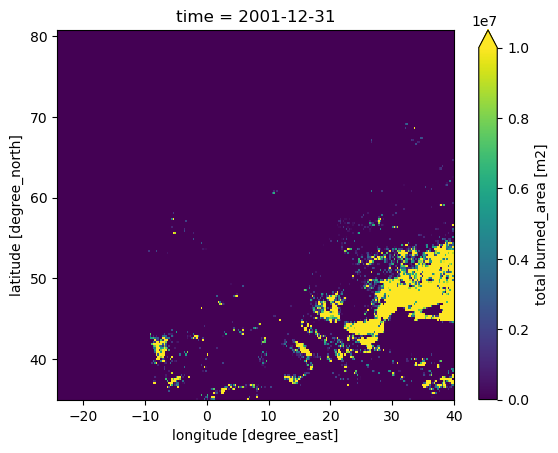

In [20]:
ba_annual.burned_area.isel(time=0).plot.imshow(vmax=1e7)

Cache the dataset to limit network access. Uncomment, if you run this NB for the first time.

In [21]:
# ba_annual.to_zarr(f"{clip_cache_dir}/ba_annual_sum.zarr", mode="w")

Reopen the cached dataset

In [22]:
ba_annual = xr.open_zarr(f"{clip_cache_dir}/ba_annual_sum.zarr")
ba_annual

<xarray.Dataset>
Dimensions:           (time: 20, lat: 183, lon: 257, nv: 2, vegetation_class: 18)
Coordinates:
  * lat               (lat) float32 80.62 80.38 80.12 ... 35.62 35.38 35.12
    lat_bnds          (lat, nv) float32 dask.array<chunksize=(183, 2), meta=np.ndarray>
  * lon               (lon) float32 -24.12 -23.88 -23.62 ... 39.38 39.62 39.88
    lon_bnds          (lon, nv) float32 dask.array<chunksize=(257, 2), meta=np.ndarray>
  * time              (time) datetime64[ns] 2001-12-31 2002-12-31 ... 2020-12-31
  * vegetation_class  (vegetation_class) int32 10 20 30 40 ... 150 160 170 180
Dimensions without coordinates: nv
Data variables:
    burned_area       (time, lat, lon) float32 dask.array<chunksize=(1, 183, 257), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    date_created:            2023-01-22T11:48:22.662232
    history:                 [{'cube_params': {'time_range': ['2001-01-01T00:...
    processing_level:        L4
    time_coverage_duration:  P7305DT0H0M0S
    time_coverage_end:       2021-01-01T00:00:00
    time_coverage_start:     2001-01-01T00:00:00
    title:                   esacci.FIRE.mon.L4.BA.MODIS.Terra.MODIS_TERRA.v5...

## Sum of Annual Burned Area sums per country

In [23]:
ba_annual_country = ba_annual.groupby(countries_subset.country_code).sum()
ba_annual_country

<xarray.Dataset>
Dimensions:           (country_code: 47, time: 20, vegetation_class: 18)
Coordinates:
  * time              (time) datetime64[ns] 2001-12-31 2002-12-31 ... 2020-12-31
  * vegetation_class  (vegetation_class) int32 10 20 30 40 ... 150 160 170 180
  * country_code      (country_code) float64 6.0 39.0 40.0 ... 165.0 166.0 167.0
Data variables:
    burned_area       (country_code, time) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    date_created:            2023-01-22T11:48:22.662232
    history:                 [{'cube_params': {'time_range': ['2001-01-01T00:...
    processing_level:        L4
    time_coverage_duration:  P7305DT0H0M0S
    time_coverage_end:       2021-01-01T00:00:00
    time_coverage_start:     2001-01-01T00:00:00
    title:                   esacci.FIRE.mon.L4.BA.MODIS.Terra.MODIS_TERRA.v5...

Compute data frame with time series for each country

In [24]:
country_names = countries_subset.country_code.attrs["country_names"]
#country_names

For all countries

In [25]:
data_frame = pd.DataFrame()
data_frame["year"] = ba_annual.time.dt.year
data_frame.set_index("year", inplace=True)

for country_code in ba_annual_country.country_code:
    country_code = int(country_code)
    if not (129 <= country_code <= 167 and country_code != 162):
        continue
    ba_per_country = ba_annual_country.burned_area.sel(country_code=country_code)   
    # display(ba_per_country)
    country_name = country_names[str(country_code)]
    data_frame[country_name] = ba_per_country

Add also Europe

In [26]:
data_frame["Europe"] = ba_annual.burned_area.where(countries_subset.europe).sum(["lon", "lat"])

In [27]:
data_frame  

,Albania,Austria,Belgium,Bulgaria,Bosnia and Herzegovina,Belarus,Switzerland,Czech Republic,Germany,Denmark,...,Norway,Poland,Portugal,Romania,Republic of Serbia,Slovakia,Slovenia,Sweden,Ukraine,Europe
year,,,,,,,,,,,,,,,,,,,,,
2001,1.151107e+08,15992066.0,0.0,7.601922e+09,1.347520e+08,7.210384e+08,0.0,5795782.0,0.0,0.0,...,11054921.0,132981040.0,9.907034e+08,6.610199e+09,7.136327e+08,18245980.0,0.0,0.0,2.741712e+10,5.303158e+10
2002,2.189518e+07,9391316.0,0.0,9.800241e+08,3.262811e+07,2.961270e+09,0.0,26885992.0,2200249.0,0.0,...,4239507.0,309537760.0,1.260476e+09,7.933247e+08,3.195194e+08,50820432.0,0.0,87044072.0,1.952653e+10,3.086711e+10
2003,3.063179e+08,14274798.0,6708083.0,2.510970e+09,1.103023e+09,1.702243e+09,5098142.0,7942368.0,18192316.0,6117771.0,...,89941984.0,563908224.0,4.766764e+09,1.228760e+09,1.543557e+09,69442064.0,1502610.0,20446228.0,4.935378e+09,2.852175e+10
2004,4.620527e+07,21358532.0,321988.0,4.950672e+09,4.652726e+07,3.819851e+08,0.0,17548342.0,3595529.0,6064104.0,...,13201502.0,78994376.0,1.433651e+09,4.240313e+09,1.058536e+09,134805632.0,858634.0,5151806.0,1.353884e+10,3.414591e+10
2005,1.548762e+08,38155576.0,375652.0,2.299370e+09,5.768951e+07,3.666906e+08,0.0,36116316.0,0.0,2414909.0,...,37672592.0,89512640.0,3.957554e+09,3.162673e+09,6.935084e+08,88385696.0,4454167.0,37350600.0,2.363365e+10,3.979723e+10
2006,5.715286e+07,37296940.0,1019628.0,4.037407e+09,5.328900e+07,1.648471e+09,0.0,14543122.0,3541867.0,4668824.0,...,24149096.0,51464404.0,8.441452e+08,3.283955e+09,8.381347e+08,43575704.0,268323.0,69656720.0,1.960075e+10,3.574705e+10
2007,1.626844e+09,6064106.0,4454167.0,2.359582e+09,5.378273e+08,3.452247e+08,1878262.0,1502609.0,751305.0,1717269.0,...,6332429.0,36330972.0,3.560651e+08,2.446787e+09,1.447765e+09,56294232.0,0.0,9176655.0,2.217032e+10,4.317365e+10
2008,3.083035e+08,10035292.0,2414909.0,2.693752e+09,1.361472e+08,2.865693e+08,0.0,5795783.0,11752560.0,965962.0,...,56347892.0,24095428.0,1.372742e+08,7.371486e+09,1.776408e+09,40355824.0,0.0,26349344.0,4.099562e+10,6.225064e+10
2009,1.450556e+08,0.0,0.0,1.544093e+09,1.627649e+08,7.657947e+08,0.0,6708081.0,2253914.0,0.0,...,2200250.0,50874092.0,9.914010e+08,3.895786e+09,2.380994e+09,11430571.0,0.0,6654414.0,2.618428e+10,4.180080e+10


# Save results to CSV

In [28]:
csv_path = f"{clip_data_dir}/ba-europe-countries.csv"

In [29]:
data_frame.to_csv(csv_path)

In [30]:
cumsum_csv_path = f"{clip_data_dir}/ba-europe-countries-cumsum.csv"

In [31]:
data_frame.cumsum().to_csv(cumsum_csv_path)

Read and plot for verification

In [32]:
data_frame = pd.read_csv(csv_path, index_col="year")  

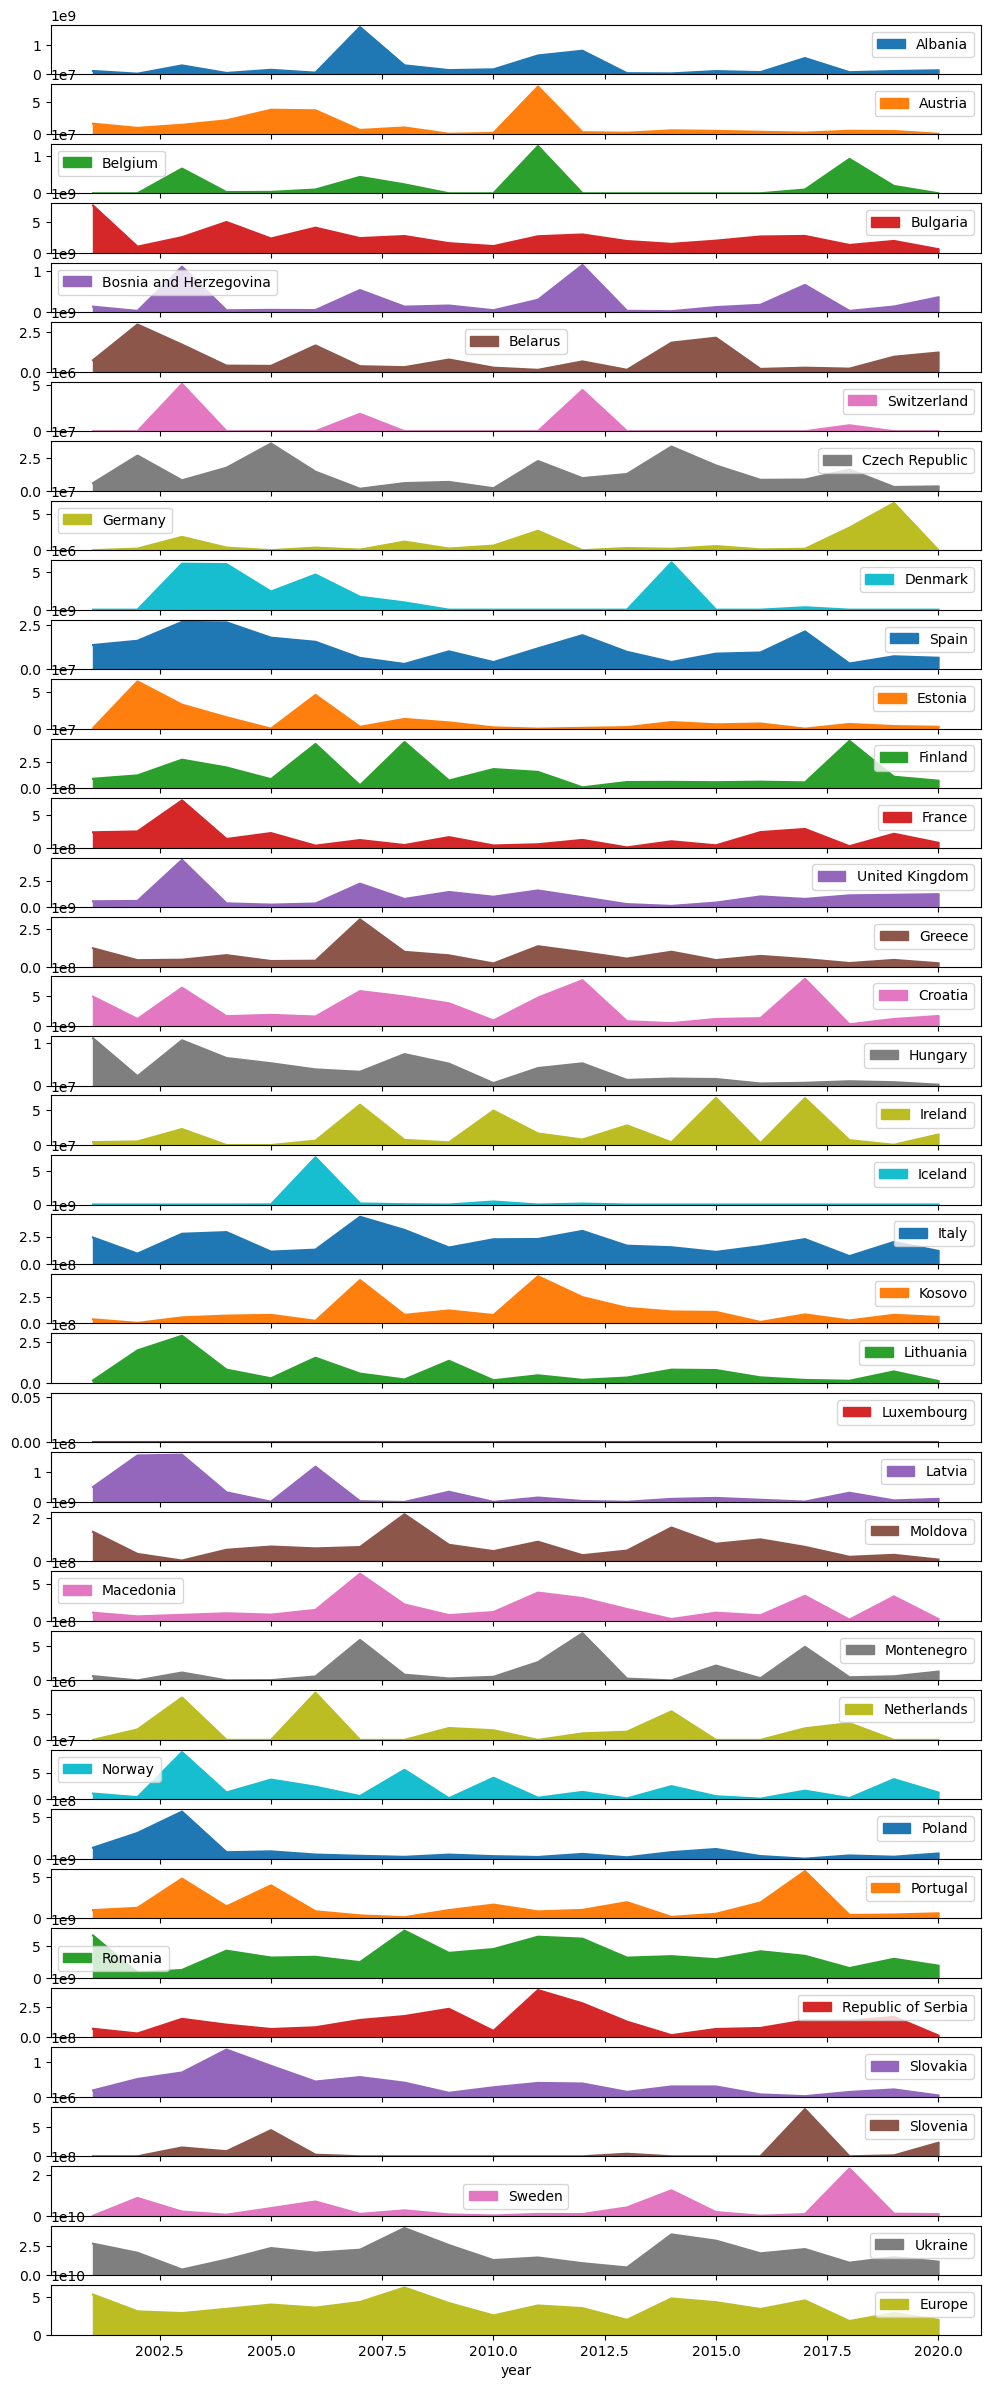

In [33]:
ax = data_frame.plot.area(figsize=(12, 30), subplots=True)
plt.show()

In [34]:
data_frame = pd.read_csv(cumsum_csv_path, index_col="year")  

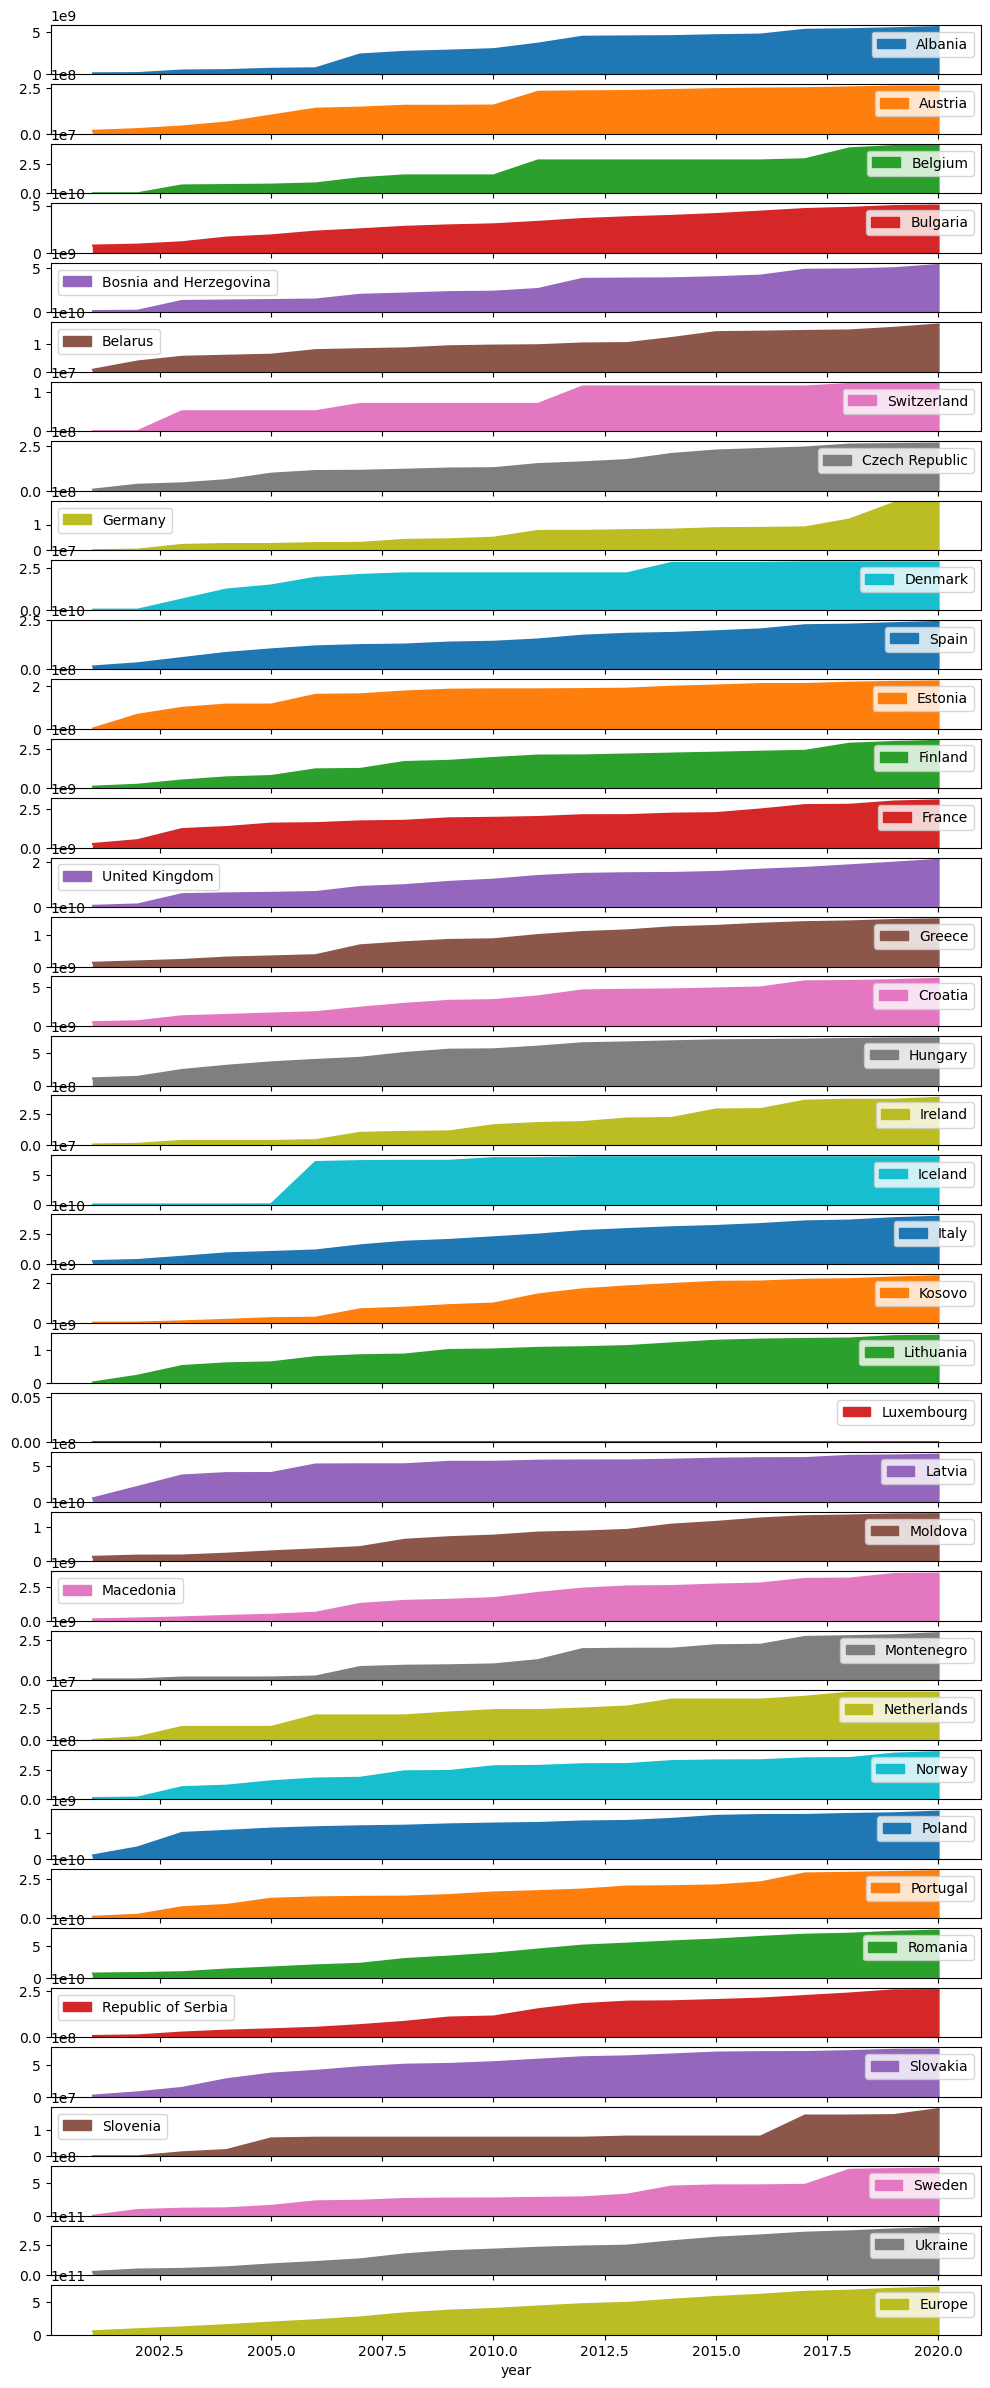

In [35]:
ax = data_frame.plot.area(figsize=(12, 30), subplots=True)
plt.show()